In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import os

In [0]:
!wget 'https://fyp-content-bucket.s3.amazonaws.com/Dataset.zip'

--2019-11-21 20:01:33--  https://fyp-content-bucket.s3.amazonaws.com/Dataset.zip
Resolving fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)... 54.231.82.162
Connecting to fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)|54.231.82.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4013338444 (3.7G) [application/zip]
Saving to: ‘Dataset.zip.2’

Dataset.zip.2       100%[===================>]   3.74G  37.0MB/s    in 1m 45s  

2019-11-21 20:03:19 (36.3 MB/s) - ‘Dataset.zip.2’ saved [4013338444/4013338444]



In [0]:
!unzip -o -q "MICC-F2000.zip"

In [3]:
path = Path("/home/tiago4k_gmail_com/MICC-F2000"); path

PosixPath('/home/tiago4k_gmail_com/MICC-F2000')

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_rotate=None, max_warp=None, max_zoom=1.0)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='train', test='test', valid_pct=0.2, ds_tfms = tfms, size=356, bs=48)

In [6]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1072 items)
x: ImageList
Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356)
y: CategoryList
Tampered,Tampered,Tampered,Tampered,Tampered
Path: /home/tiago4k_gmail_com/MICC-F2000;

Valid: LabelList (268 items)
x: ImageList
Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356)
y: CategoryList
Tampered,Authentic,Tampered,Tampered,Tampered
Path: /home/tiago4k_gmail_com/MICC-F2000;

Test: LabelList (660 items)
x: ImageList
Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356),Image (3, 356, 356)
y: EmptyLabelList
,,,,
Path: /home/tiago4k_gmail_com/MICC-F2000

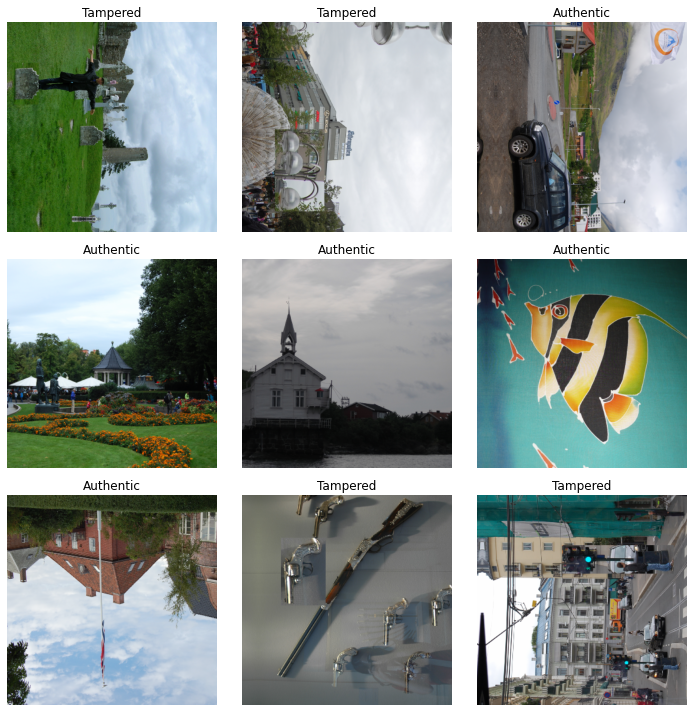

In [14]:
data.show_batch(rows=3, figsize=(10,10))

In [15]:
print(data.classes)
len(data.classes),data.c

['Authentic', 'Tampered']


(2, 2)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


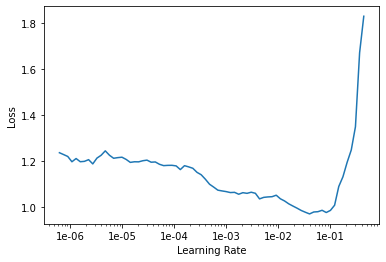

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.930785,0.601981,0.201493,0.798507,01:26
1,0.786224,0.532925,0.152985,0.847015,01:24
2,0.663844,0.357413,0.104478,0.895522,01:24
3,0.555950,0.300182,0.115672,0.884328,01:25
4,0.469106,0.195364,0.070896,0.929105,01:25
5,0.399099,0.195415,0.048507,0.951493,01:25
6,0.328289,0.228197,0.063433,0.936567,01:24
7,0.274417,0.174927,0.048507,0.951493,01:24
8,0.235297,0.155342,0.052239,0.947761,01:24
9,0.220737,0.154019,0.048507,0.951493,01:24


In [0]:
learn.save('attempt-1-resnet50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


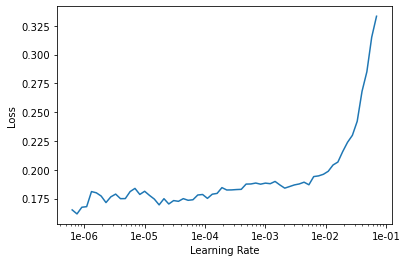

In [11]:
learn.lr_find()
learn.recorder.plot()

Min numerical gradient: 1.91E-06
Min loss divided by 10: 7.59E-08


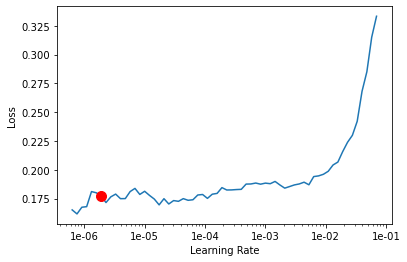

In [12]:
learn.recorder.plot(suggestion=True)

In [13]:
learn.unfreeze()
learn.fit_one_cycle(15, max_lr=slice(1e-05, 1e-06))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.195998,0.151116,0.048507,0.951493,01:23
1,0.193242,0.150308,0.048507,0.951493,01:23
2,0.192662,0.147976,0.044776,0.955224,01:22
3,0.182032,0.145636,0.029851,0.970149,01:23
4,0.168330,0.139417,0.029851,0.970149,01:23
5,0.174257,0.144740,0.029851,0.970149,01:23
6,0.172574,0.143815,0.029851,0.970149,01:23
7,0.164134,0.153425,0.044776,0.955224,01:22
8,0.166154,0.149090,0.037313,0.962687,01:23
9,0.172584,0.147213,0.029851,0.970149,01:23


In [0]:
learn.save('attempt-2-50resnet')

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

In [16]:
interp.most_confused(min_val=2)

[('Authentic', 'Tampered', 8)]

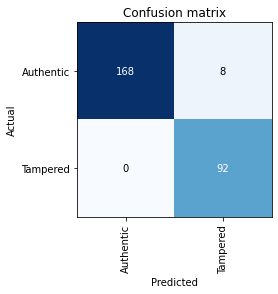

In [17]:
interp.plot_confusion_matrix()

Predictions

In [0]:
learn.export()

In [19]:
path = '/home/tiago4k_gmail_com/MICC-F2000/test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)

/home/tiago4k_gmail_com/MICC-F2000/test/Tampered/
/home/tiago4k_gmail_com/MICC-F2000/test/Authentic/


In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [21]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_real/total_real) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
401/429. Accuracy = 93.47%
Images Classified As Tampered
231/231. Accuracy = 100.00%


In [22]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 95.340%


In [0]:
img = open_image('/home/tiago4k_gmail_com/pogba_fake.jpg')

In [28]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Authentic